In [1]:
import wave 
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
from graphviz import Source
from IPython.display import SVG, display, HTML, Audio
# style = "<style>svg{width: 10% !important; height: 10% !important;} </style>"
# os.environ["PATH"] += os.pathsep + 'G:\\soft\\graphviz\\bin' + os.pathsep + 'G:\\soft\\graphviz' 

In [3]:
data_path = 'wav_data/'
wav_path = os.path.join(data_path, "wav_files")
files_f = [line[:-1] for line in open(os.path.join(data_path, "f_wav_list.txt"), "r").readlines()]
files_m = [line[:-1] for line in open(os.path.join(data_path, "m_wav_list.txt"), "r").readlines()]

In [4]:
audio_df = pd.DataFrame([{'filename': file, 'sex': 'm'} for file in files_m] + [{'filename': file, 'sex': 'f'} for file in files_f])

In [5]:
audio_df.head()

,filename,sex
0,A30001A1.wav,m
1,A30001A2.wav,m
2,A30001A3.wav,m
3,A30001A4.wav,m
4,A30001A5.wav,m


In [6]:
f_example = os.path.join(wav_path, files_f[0]) 
m_example = os.path.join(wav_path, files_m[1]) 
sampling_rate_f, data_f = wavfile.read(f_example)
sampling_rate_m, data_m = wavfile.read(m_example)

In [7]:
Audio(f_example, rate = sampling_rate_f)

In [8]:
Audio(m_example, rate = sampling_rate_m)

Text(0.5, 1.0, 'Male voice')

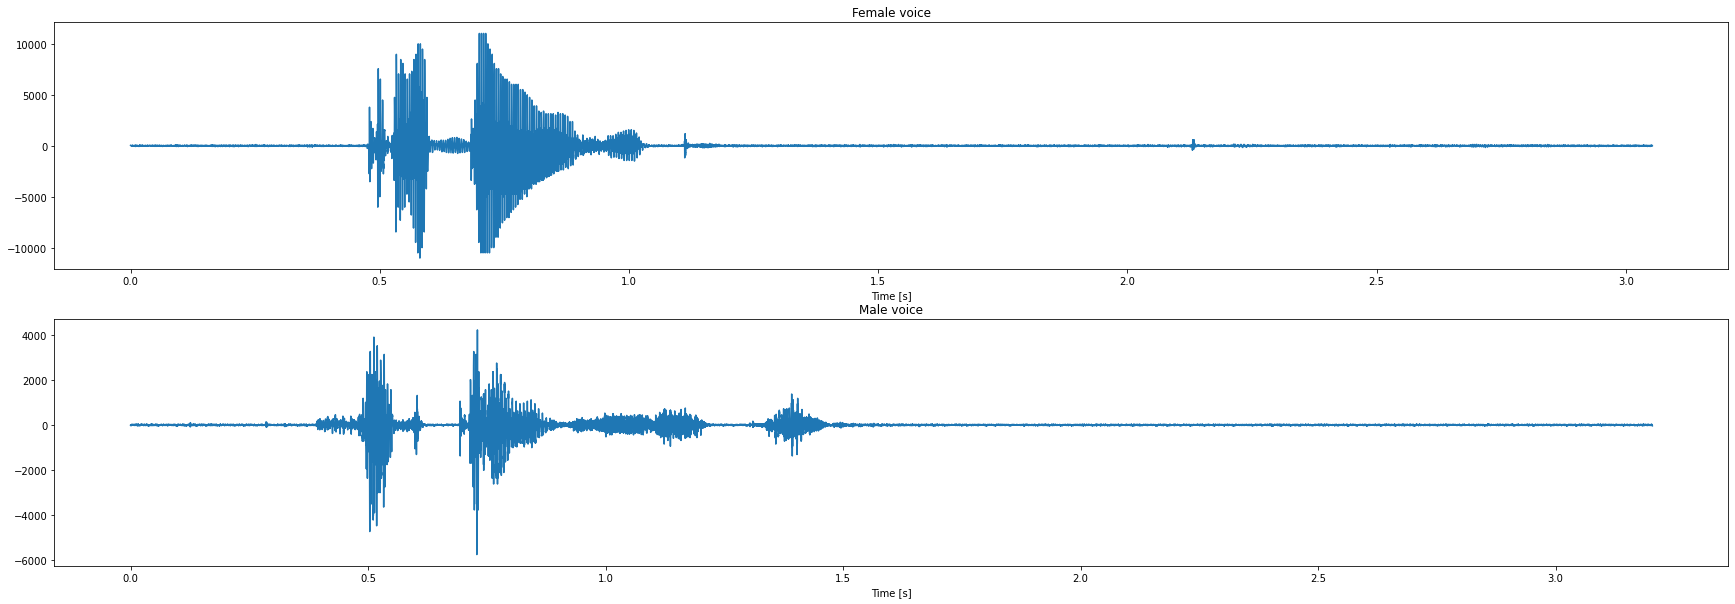

In [9]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 1, 1)

length = data_f.shape[0] / sampling_rate_f 
time = np.linspace(0., length, data_f.shape[0])

plt.plot(time, data_f)
plt.xlabel('Time [s]')
plt.title('Female voice')

plt.subplot(2, 1, 2)

length = data_m.shape[0] / sampling_rate_m 
time = np.linspace(0., length, data_m.shape[0])

plt.plot(time, data_m)
plt.xlabel('Time [s]')
plt.title('Male voice')

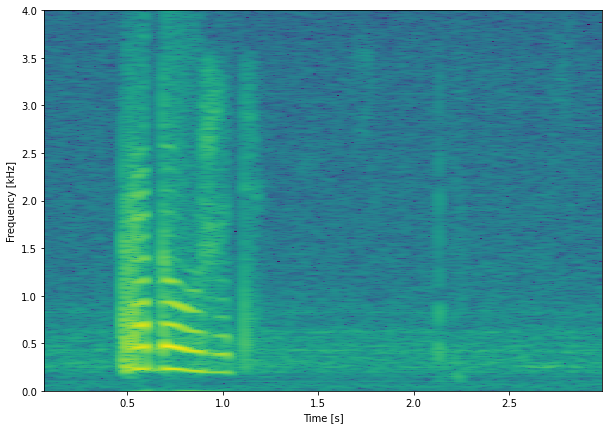

In [10]:
# draw a spectrogram 
# https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html#idm140212626303376

M = 1024

from scipy import signal

freqs, times, Sx = signal.spectrogram(data_f, fs=sampling_rate_m, window='hanning',
                                      nperseg=M, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(10, 7))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

In [11]:
# compare praat & YAAPT pitch tracking

import parselmouth
import amfm_decompy.pYAAPT as pYAAPT
import amfm_decompy.basic_tools as basic

# praat
snd_m = parselmouth.Sound(f_example)
snd_f = parselmouth.Sound(m_example)

# praat pitches 
pitch_m = snd_m.to_pitch()
pitch_f = snd_f.to_pitch()

# YAAPT
signal_m = basic.SignalObj(f_example)
signal_f = basic.SignalObj(m_example)

# YAAPT pitches 
pitchY_m = pYAAPT.yaapt(signal_m, frame_length=40, tda_frame_length=40, f0_min=75, f0_max=600)
pitchY_f = pYAAPT.yaapt(signal_f, frame_length=40, tda_frame_length=40, f0_min=75, f0_max=600)

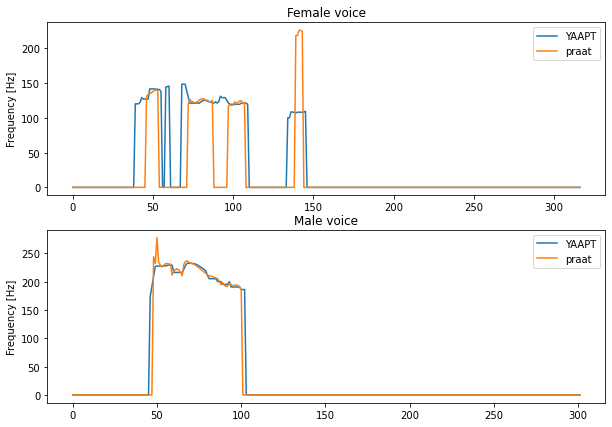

In [12]:
# compare results

plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)
plt.plot(pitchY_f.samp_values, label='YAAPT')
plt.plot(pitch_f.selected_array['frequency'], label='praat')
plt.title("Female voice")
plt.ylabel('Frequency [Hz]')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pitchY_m.samp_values, label='YAAPT')
plt.plot(pitch_m.selected_array['frequency'], label='praat')
plt.title("Male voice")
plt.ylabel('Frequency [Hz]')
plt.legend()

plt.show()

In [13]:
# Using praat pitch tracking

def get_pitch_praat(wav_path):
    snd = parselmouth.Sound(wav_path)
    pitch_data = snd.to_pitch()
    pitch_nonzero = [value for value in pitch_data.selected_array['frequency'] if value > 0]
    min_pitch = np.min(pitch_nonzero)
    mean_pitch = np.mean(pitch_nonzero)
    max_pitch = np.max(pitch_nonzero)
    return min_pitch, mean_pitch, max_pitch                    

In [14]:
audio_df.head()

,filename,sex
0,A30001A1.wav,m
1,A30001A2.wav,m
2,A30001A3.wav,m
3,A30001A4.wav,m
4,A30001A5.wav,m


In [15]:
p_min_res, p_mean_res, p_max_res, p_diff_res = [], [], [], []
for _, row in audio_df.iterrows():
    p_min, p_mean, p_max = get_pitch_praat(os.path.join(wav_path, row['filename']))
    p_min_res.append(p_min)
    p_mean_res.append(p_mean)
    p_max_res.append(p_max)
    p_diff_res.append(p_max - p_min)
audio_pitch_df_praat = pd.DataFrame({'pitch_min': p_min_res,
                                     'pitch_mean': p_mean_res,
                                     'pitch_max': p_max_res,
                                     'pitch_range': p_diff_res})

In [16]:
audio_pitch_df_praat.head()

,pitch_min,pitch_mean,pitch_max,pitch_range
0,118.589458,122.407448,138.360027,19.770569
1,117.375462,138.017585,226.071884,108.696422
2,116.301870,125.624709,149.842199,33.540329
3,117.980596,128.680423,142.356765,24.376169
4,113.709659,128.207538,149.434895,35.725236


In [17]:
audio_df = audio_df.merge(audio_pitch_df_praat, left_index=True, right_index=True)

In [18]:
audio_df.sample(5)

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range
58,A30003C1.wav,m,74.444368,139.086441,170.318105,95.873737
72,A30003N1.wav,m,130.354557,156.372103,554.429076,424.074519
39,A30001T1.wav,m,123.451079,190.120312,419.844003,296.392924
86,A30003S6.wav,m,118.064528,165.406289,587.550213,469.485684
193,A30002T2.wav,f,188.557765,222.036437,262.394726,73.836962


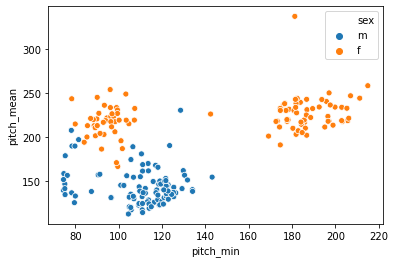

In [19]:
ax = sns.scatterplot(x="pitch_min", y="pitch_mean",
                     hue="sex", data=audio_df)

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

from xgboost import XGBClassifier

In [21]:
le = LabelEncoder()
audio_df['sex'] = le.fit_transform(audio_df['sex'])

In [22]:
train_cols = ['pitch_min', 'pitch_mean', 'pitch_max', 'pitch_range']

In [23]:
X_train, X_test, y_train, y_actual = train_test_split(audio_df[train_cols], audio_df['sex'], test_size=0.33) 

In [24]:
### XGBoost ###  
xgb_clf = XGBClassifier()
xgb_params_grid = {
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'classifier__gamma': [0, 0.2, 0.5]
}

gs = GridSearchCV(xgb_clf, xgb_params_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
y_pred_xgb = gs.best_estimator_.predict(X_test)

roc_auc_score:  0.9714285714285714


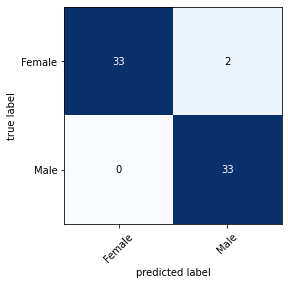

In [25]:
print('roc_auc_score: ', roc_auc_score(y_actual, y_pred_xgb))
cm = confusion_matrix(y_actual, y_pred_xgb)
_ = plot_confusion_matrix(cm, class_names=['Female', 'Male'])

In [26]:
# show mistakes
test_df = audio_df.loc[X_test.index].copy()
test_df['pred_xgb'] = y_pred_xgb
test_df[test_df['sex'] != y_pred_xgb]

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range,pred_xgb
199,A30002X2.wav,0,98.908515,170.656269,421.669096,322.760581,1
203,A30002X6.wav,0,93.332168,235.940075,576.559138,483.226970,1


In [27]:
### Random forest ### 
forest_params_grid = {
    'n_estimators': list(range(10, 100, 10)),
    'max_depth': [1, 2]
    }

forest = RandomForestClassifier()

gs_forest = GridSearchCV(forest, forest_params_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs_forest.fit(X_train, y_train)
y_pred_forest = gs_forest.best_estimator_.predict(X_test)

roc_auc_score:  0.9571428571428571


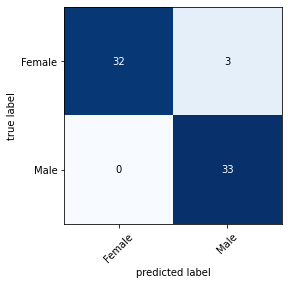

In [28]:
print('roc_auc_score: ', roc_auc_score(y_actual, y_pred_forest))
cm = confusion_matrix(y_actual, y_pred_forest)
_ = plot_confusion_matrix(cm, class_names=['Female', 'Male'])

In [29]:
# show mistakes
test_df['pred_forest'] = y_pred_forest
test_df[test_df['sex'] != y_pred_forest]

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range,pred_xgb,pred_forest
199,A30002X2.wav,0,98.908515,170.656269,421.669096,322.760581,1,1
203,A30002X6.wav,0,93.332168,235.940075,576.559138,483.226970,1,1
157,A30002A5.wav,0,78.267985,243.309044,514.462560,436.194575,0,1


In [30]:
### Logistic regression ### 
regr = LogisticRegression()
regr.fit(X_train, y_train)
y_pred_logreg = regr.predict(X_test)

roc_auc_score:  0.9857142857142857


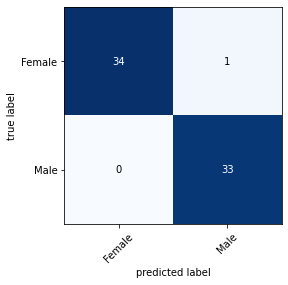

In [31]:
print('roc_auc_score: ', roc_auc_score(y_actual, y_pred_logreg))
cm = confusion_matrix(y_actual, y_pred_logreg)
_ = plot_confusion_matrix(cm, class_names=['Female', 'Male'])

In [32]:
# show mistakes
test_df['pred_logreg'] = y_pred_logreg
test_df[test_df['sex'] != y_pred_logreg]

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range,pred_xgb,pred_forest,pred_logreg
199,A30002X2.wav,0,98.908515,170.656269,421.669096,322.760581,1,1,1


In [33]:
### Do a 2vs1 vote ### 
import statistics 
from statistics import mode

def voting_predict(row):
    return mode([row['pred_xgb'] , row['pred_forest'], row['pred_logreg']])

In [34]:
test_df['final_predict'] = test_df.apply(voting_predict, axis=1)

In [35]:
test_df.sample(10)

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range,pred_xgb,pred_forest,pred_logreg,final_predict
188,A30002S6.wav,0,89.097690,210.421143,301.931050,212.833360,0,0,0,0
91,A30003T2.wav,1,121.888993,142.096813,170.537639,48.648646,1,1,1,1
193,A30002T2.wav,0,188.557765,222.036437,262.394726,73.836962,0,0,0,0
136,A30000S5.wav,0,186.681647,242.699505,336.201940,149.520293,0,0,0,0
26,A30001O7.wav,1,110.931679,124.213113,137.509682,26.578003,1,1,1,1
30,A30001S1.wav,1,74.623747,158.249055,590.191487,515.567740,1,1,1,1
90,A30003T1.wav,1,121.145931,149.798122,174.904444,53.758513,1,1,1,1
35,A30001S6.wav,1,110.956594,161.125908,391.753720,280.797126,1,1,1,1
121,A30000M1.wav,0,175.963887,236.542386,336.651945,160.688059,0,0,0,0
19,A30001M1.wav,1,106.773943,154.102140,596.400024,489.626082,1,1,1,1


roc_auc_score:  0.9714285714285714


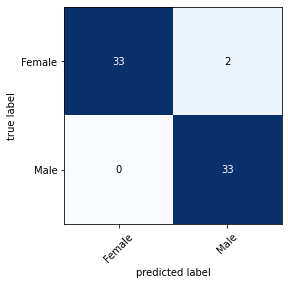

In [36]:
print('roc_auc_score: ', roc_auc_score(test_df['sex'], test_df['final_predict']))
cm = confusion_matrix(test_df['sex'], test_df['final_predict'])
_ = plot_confusion_matrix(cm, class_names=['Female', 'Male'])

In [37]:
# show mistakes after bagging    
encoded_cols = ['sex', 'pred_xgb', 'pred_forest', 'pred_logreg', 'final_predict']
for col in encoded_cols:
    test_df[col] = le.inverse_transform(test_df[col])
    
test_df[test_df['sex'] != test_df['final_predict']]

,filename,sex,pitch_min,pitch_mean,pitch_max,pitch_range,pred_xgb,pred_forest,pred_logreg,final_predict
199,A30002X2.wav,f,98.908515,170.656269,421.669096,322.760581,m,m,m,m
203,A30002X6.wav,f,93.332168,235.940075,576.559138,483.226970,m,m,f,m
